In [79]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
from matplotlib.colors import ListedColormap
import sys
from itertools import chain
import time

np.set_printoptions(threshold=sys.maxsize)

In [80]:
### KNN implementation

# HELPER FUNCTIONS

def euclidean_distance(row1, row2):
    """Calculates the distance between points

    Args:
      x1 (array): coordinate vector of point 1
      x2 (array): coordinate vector of point 2

    Returns:
      distance: euclidean distance between point 1 and 2 (scalar)"""
    
    return np.linalg.norm(row1-row2)

def accuracy_metric(actual, predicted):
    """Calculates the accuracy of a prediction

    Args:
      actual (array): array of actual labels
      predicted (array): array of predicted labels

    Returns:
      accuracy (int): accuracy of the prediction"""
    
    return (actual == predicted).mean()
    
def generalization_err(y_pred, y_test):
    """Calculates the generalization error, taking into account bias and variance errors

    Args:
      y_test (array): array of actual labels
      y_pred (array): array of predicted labels

    Returns:
      generalization_err (int): estimated generalization error avg_expected_loss + avg_bias + avg_var
      
    """
  
    return np.mean((y_pred != y_test)**2)

In [81]:
# def classify(current_point, all_points, labels, k):
#     """For a given un-labeled point and a set of other points and their labels,
#     determines the current's point label by majority vote of the k nearest neighbours. """


#     distances = []
#     for point, label in zip(all_points, labels):
#         #calculate dist from every other point
#         dist = euclidean_distance(current_point, point) 
#         #save neighbour distance and its label information
#         distances.append((dist, label))

#     # Sorting distance list by distance
#     distances.sort(key=lambda tup: tup[0])

#     # Truncating distance list to get neighbors, in an array
#     neighbors = np.array(distances[:k])

#     # Now actually classifying the point
#     # Dealing with the tie case
#     predicted_class = (np.random.randint(2, size = 1))

#     # Dealing with standard cases
#     if neighbors[:,1].mean() > 0.5:
#       predicted_class = 1

#     elif neighbors[:,1].mean() < 0.5:
#       predicted_class = 0
    
#     return predicted_class


# def run_knn(X_train, X_test, y_train, y_test, S_test, k):
    
#     """KNN running function.
    
#     Calculates a K-Nearest Neighbors classification on a test set given a train set.

#     Args:
#       X_train (vector): array of training points
#       X_test (vector): array of testing datapoints
#       y_train (vector): array of training labels
#       y_test (vector): array of testing labels. Used to compute accuracy
#       S_test (vector): size of the testing set
#       k (scalar) : number of nerest neighbors to consider


#     Returns:
#       accuracy (scalar): accuracy of the prediction
#       class_prediction (1D array): array of updated labels
#     """
    
#     class_prediction = np.ones((S_test))
#     for i in range(S_test):
#         class_prediction[i] = classify(X_test[i], X_train, y_train, k)
            
#     accuracy = accuracy_metric(y_test, class_prediction)
    
#     return accuracy, class_prediction

In [82]:
### DATA GENERATION FUNCTIONS

def generate_h_Sv(S = 100):
    """Generates S random labelled datapoints in range [0,1], following h_{s,v}

    Args:
      S (scalar): desired amount of datapoints to generate

    Returns:
      X: 2 by S matrix of coordinates data  (columns: 'xcoord', 'ycoord')
      y: vector of labels
    """
    
    #random generation of data points
    X = np.random.uniform(low=0.0, high=1.0, size=(S,2))
    
    #random generation of labels
    y = np.random.randint(2, size=S)
    
    return X, y

def data_generation(S, X_h = None, y_h = None, bias = 0.2):
    """Given an hS,v the underlying probability distribution ph(x,y) is determined by 
    sampling an x uniformly at random from [0, 1]2 and then its corresponding y value
    is then generated by flipping biased coin P(heads) = 0.8/P(tails) = 0.2 if heads 
    comes up then y = hS,v(x) otherwise y is sampled uniformly at random from {0, 1}.

    Args:
      S (scalar): desired amount of datapoints to generate
      bias: The percentage of point which are assigned random labels
      X_h
      y_h

    Returns:
      X: 3 by S matrix of labelled data  (columns: 'xcoord', 'ycoord', 'label' )
    """

    # If an h_Sv and underlying baseline is not provided generate it
    if X_h is None and y_h is None:
      X_h, y_h = generate_h_Sv()

    # Initialise data array and random labels
    X = np.random.uniform(low=0.0, high=1.0, size=(S,2))
    y = np.random.randint(2, size=S)


    #separate data into biased and unbiased
    noisy_data = X[:int(round(S*bias))]
    noisy_labels = y[:int(round(S*bias))]
    clean_data = X[int(round(S*(bias))):]
    clean_labels = y[int(round(S*(bias))):]
    
    #get unbiased labels according to hS,v
    _, clean_labels = run_knn(X_h, clean_data, y_h, clean_labels, clean_labels.shape[0], k = 3)
    
    clean = np.insert(clean_data, 2,  clean_labels.T, axis=1)
    noisy = np.insert(noisy_data, 2,  noisy_labels , axis=1)
    
    # merge biased and unbiased datasets
    data = np.concatenate((clean, noisy), axis=0)
    
    X, y = data[:,:2], data[:,2]
    
    #returning a 2d vector of coordinates and a 1d vector of labels
    return X, y

def data_generation_q3(S, X_h, y_h):
    """Given an hS,v the underlying probability distribution ph(x,y) is deter- mined by 
    sampling an x uniformly at random from [0, 1]2 and then its corresponding y value
    is then generated by flipping biased coin P(heads) = 0.8/P(tails) = 0.2 if heads 
    comes up then y = hS,v(x) otherwise y is sampled uniformly at random from {0, 1}.

    Args:
      S (scalar): desired amount of datapoints to generate
      bias: defined in coursework details
      X_h
      y_h

    Returns:
      X: 3 by S matrix of labelled data  (columns: 'xcoord', 'ycoord', 'label' )
    """
    # Generate     
    X,y = generate_h_Sv(S)
    
    #generate data according to hS,v
    acc , y = run_knn(X_h, X, y_h, y, S, k = 3)
    
    #returning a 2d vector of coordinates and a 1d vector of labels
    return X, y



### CLASS FUNCTIONS    


def classify(current_point, all_points, labels, k):
    """For a given un-labeled point and a set of other points and their labels,
    determines the current's point label by majority vote of the k nearest neighbours. """


    distances = []
    for point, label in zip(all_points, labels):
        #calculate dist from every other point
        dist = euclidean_distance(current_point, point) 
        #save neighbour distance and its label information
        distances.append((dist, label))

    # Sorting distance list by distance
    distances.sort(key=lambda tup: tup[0])

    # Truncating distance list to get neighbors, in an array
    neighbors = np.array(distances[:k])

    # Now actually classifying the point
    # Dealing with the tie case
    predicted_class = (np.random.randint(2, size = 1))

    # Dealing with standard cases
    if neighbors[:,1].mean() > 0.5:
      predicted_class = 1

    elif neighbors[:,1].mean() < 0.5:
      predicted_class = 0
    
    return predicted_class


def run_knn(X_train, X_test, y_train, y_test, S_test, k):
    
    """KNN running function.
    
    Calculates a K-Nearest Neighbors classification on a test set given a train set.

    Args:
      X_train (vector): array of training points
      X_test (vector): array of testing datapoints
      y_train (vector): array of training labels
      y_test (vector): array of testing labels. Used to compute accuracy
      S_test (vector): size of the testing set
      k (scalar) : number of nerest neighbors to consider


    Returns:
      accuracy (scalar): accuracy of the prediction
      class_prediction (1D array): array of updated labels
    """
    
    class_prediction = np.ones((S_test))
    for i in range(S_test):
        class_prediction[i] = classify(X_test[i], X_train, y_train, k)
            
    accuracy = accuracy_metric(y_test, class_prediction)
    
    return accuracy, class_prediction

### PLOTTING FUNCTIONS

def plot_hypothesis(X,y,num_neighbors):
    """Scatters data with respect to classes

    Args:
      X (2*S matrix): data points to scatter
      y (1*S matrix): labels of given data points

    Returns:
      scatterplot of X given labels y
      fcontour of different classes
    """
    
    # building meshgrid
    
    h = 0.02
    margin = 0.1
    cmap_light = ListedColormap(["orange", "cyan", "cornflowerblue"])
    x_min, x_max = X[:, 0].min() - margin, X[:, 0].max() + margin
    y_min, y_max = X[:, 1].min() - margin, X[:, 1].max() + margin
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    X_test = np.c_[xx.ravel(), yy.ravel()]
    
    # initialising an array of labels to update
    y_test = np.ones((X_test.shape[0]))
    
    # running KNN on meshgrid
    acc, Z = run_knn(X, X_test , y, y_test, X_test.shape[0], num_neighbors)

    # format new labels for fcontour function
    Z = (Z).reshape(xx.shape)

    
    plt.figure(figsize = (8,6))
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    # plotting hypothesis generated datapoint sand meshgrid prediction using the KNN implementation
    plt.contourf(xx, yy, Z, cmap=cmap_light);
    #[plt.scatter(X[:,0][i],X[:,1][i], c= 'y') for i in range(len(y)) if y[i] == 0]
    #[plt.scatter(X[:,0][i],X[:,1][i], c= 'b') for i in range(len(y)) if y[i] == 1]
    
    for i in range(len(y)):
      if y[i] == 0:
        plt.scatter(X[:,0][i],X[:,1][i], c= 'y');
      else:
        plt.scatter(X[:,0][i],X[:,1][i], c= 'b');
    plt.savefig('hypothesis.png')
    #plt.show()

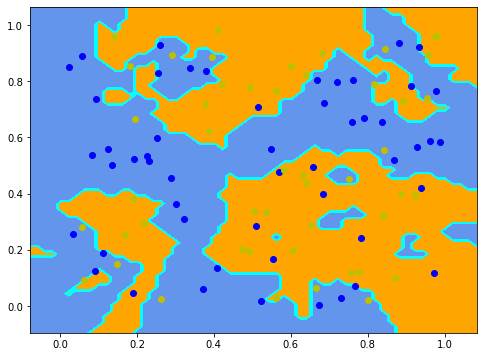

In [83]:
S = 100
num_neighbors = 3
# building a hypothesis
X_h, y_h = generate_h_Sv(S)            
# plotting this hypothesis
plot_hypothesis(X_h, y_h, num_neighbors = 3)

In [84]:
def protocol_a(k, iterations, S_train, S_test):
    """
    
    Runs Protocol A and determines the mean Estimated Generalization Error (EGE)
    as a function of k.

    Args:
      k (list): list of k values
      iterations (int): number of iterations to run for every k
      S_train (int): size of training dataset
      S_test (int): size of testing dataset

    Returns:
      ege (array): array of EGE for every selected value of k
    """
    ege = np.ones(len(k))    
    bias = 0.2
    
    for w, k_value in enumerate(k):
        acc = np.ones(iterations)
        err = np.ones(iterations)
        
        print('k :',k_value)
        for i in range(iterations):            
            #sample h

            X_h, y_h = generate_h_Sv(100)
            
            # building KNN
            start = time.time()
            X_train, y_train = data_generation(S_train, X_h, y_h)
            X_test, y_test = data_generation(S_test, X_h, y_h)
            end = time.time()
            print(f'Building data took {start - end} seconds')
            
            acc[i], y_pred = run_knn(X_train, X_test, y_train, y_test, S_test, k_value) 
            
            err[i] = generalization_err(y_pred, y_test)
            
        ege[w] = np.mean(err[i])
        
        print('estimated generalization error',np.mean(err[i]))
        
    return ege

In [85]:
k = list(range(1, 49))
ege = protocol_a(k, iterations =100 , S_train = 4000, S_test = 1000)
np.savetxt("estimatedgeneralizationerror.csv", ege, delimiter=",")

k : 1
Building data took -0.6789898872375488 seconds


IndexError: index 400 is out of bounds for axis 0 with size 400

In [ ]:
### Plotting estimated generalisation error as a function of k
fig = plt.figure()
plt.title('Estimated Generalization Error as a function of k')
plt.xlabel('$k$')
plt.ylabel('Estimated Generalization Error')
plt.plot(k,ege)
plt.savefig("ege.png")
plt.show()

In [ ]:
def protocol_b(m, k, iterations, S_test):
    """
    Runs Protocol B and determines the optimal k as a function of the number
    of training points (m)

    Args:
      m (array): list of m values
      k (list): list of k values
      iterations (int): number of iterations to run for every k
      S_test (int): size of testing dataset

    Returns:
      est_optimal (array): array of optimal k values for every m (training set size)
      plot : plot of m versus optimal k
    """
    optimal = np.ones(iterations)    
    
    for p, m_value in enumerate(m):
    
        optimal_k = np.ones(iterations)
        print('m:', m_value)
        for i in range(iterations):
            
            acc = np.ones(iterations)
            ege = np.ones(len(k))
            
            for w, k_value in enumerate(k):
                #sample h
                X_h, y_h = generate_h_Sv(100)
            
                # building KNN
                X_train, y_train = data_generation_q3(m_value, X_h, y_h)
                X_test, y_test = data_generation_q3(S_test, X_h, y_h)
                

                # running KNN
                acc[i], y_pred = run_knn(X_train, X_test, y_train, y_test, S_test, k_value) 
                ege[w] = generalization_err(y_pred, y_test)


            # save k value with the minimum generalization
            optimal_k[i] = min(ege)
        # save the most optimal result
        optimal[p] = np.mean(optimal_k) 
    
    
    return est_optimal


In [ ]:
k = list(range(1, 49))
m = [100, 500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]
est_optimal = protocol_b(m, k, iterations = 10, S_test = 10)
np.savetxt("optimalk.csv", ege, delimiter=",")

In [ ]:
### Plotting the optimal k as a function of the number of training points
fig = plt.figure()
plt.title('The optimal k as a function of the number of training points')
plt.xlabel('optimal $k$')
plt.ylabel('$m$')
plt.plot(m,est_optimal)
plt.savefig("optimalk.png")
plt.show()